In [88]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D


# Importing and Visualizing Data
Data is downloaded to home directory. 

Using Kaggle instead

In [89]:
# This one takes 3 minutes
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\mulugetah\.cache\kagglehub\datasets\jessicali9530\stanford-dogs-dataset\versions\2


In [90]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import os
import pandas as pd

# Loading data into the memory is not efficient since it doesn't have enough memory for that much data
# Load filenames into dataframe instead

images = []

labels = []

label_count = 0

images_path = path + r"/images/Images/"

for label in os.listdir(images_path):
    label_path = images_path + label + "/"
    label_count += 1
    for file in os.listdir(label_path):
        images.append(label_path + file)
        labels.append(label.split('-')[1])

df = pd.DataFrame({"image_path" : images, "label": labels})


df = df[:700]

In [91]:
X_train, X_temp = train_test_split(df, test_size=0.2, stratify=df["label"], random_state = 42)

label_test_val = X_temp['label']

# 10%.   10%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (560, 2)
The shape of test data (70, 2)
The shape of validation data (70, 2)


In [92]:
# parameters
image_size = 255 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 1 # Number of files/images processed at once

In [93]:
# Applyingimage data gernerator to train and test data
datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255, # to bring the image range from 0..255 to 0..1
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0, # randomly zoom image 
            width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False) # randomly flip images

train_generator = datagen.flow_from_dataframe(X_train,
                                                    x_col= 'image_path',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode="categorical",
                                                   )
val_generator = datagen.flow_from_dataframe(X_val, 
                                                 x_col= 'image_path',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode="categorical",
                                                )

test_generator = datagen.flow_from_dataframe(X_test, 
                                                  x_col= 'image_path',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                 )

Found 560 validated image filenames belonging to 4 classes.
Found 70 validated image filenames belonging to 4 classes.
Found 70 validated image filenames belonging to 4 classes.


In [97]:
# use the data generator
num_classes = len(test_generator.class_indices)

# CNN
Everything after this is specific to Convolutional Nueral Networks but you can try to look at how it is set up.

In [98]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_classes,activation='softmax')) # Softmax for binary classification

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 253, 253, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │   125,960,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,984,580 (480.59 MB)

 Trainable params: 125,983,364 (480.59 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [99]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [100]:
train_generator.target_size

(255, 255)

In [101]:
fitted = model.fit(train_generator,
                    validation_data = val_generator, 
                    epochs = 1,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

c:\Users\mulugetah\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


560/560 ━━━━━━━━━━━━━━━━━━━━ 446s 785ms/step - accuracy: 0.3593 - loss: 0.5814 - val_accuracy: 0.2286 - val_loss: 6.2746


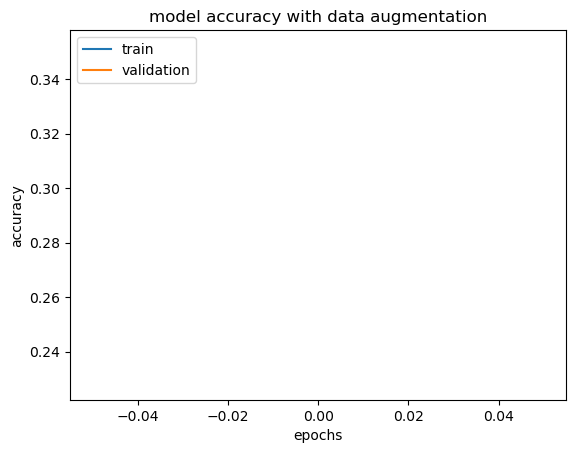

In [102]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy with data augmentation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Using Classical Machine Learning
We will be using KMeans in order to try to classify the dog breeds. It probably won't perform well. 

As a start, we should pick the least well classified breeds and try to get the best scores we can before moving to DNN and CNNs. The image shows the best accuracies achieved in each breed. We will be trying to get the best in the bottom, say 5. 

![image](bar_graph_full.png)